In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE


# models
from sklearn.linear_model import LogisticRegression # LR
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.tree import DecisionTreeClassifier # DT
from sklearn.ensemble import RandomForestClassifier # RF
from xgboost import XGBClassifier # XGBM
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from  lightgbm import LGBMClassifier # Light GBM


# evaluation
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

sns.set_palette('dark')
sns.set_style('darkgrid')

In [ ]:
df = pd.read_csv("../content/drive/MyDrive/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,index,Exited
0,0,0.7963
1,1,0.2037


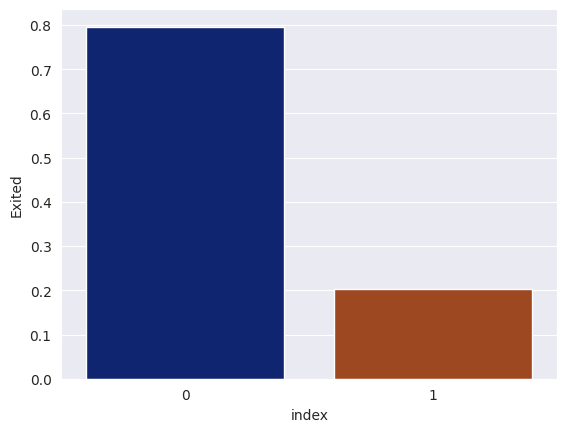

In [ ]:
density = df['Exited'].value_counts(normalize=True).reset_index()
sns.barplot(data=density, x='index', y='Exited', );
density

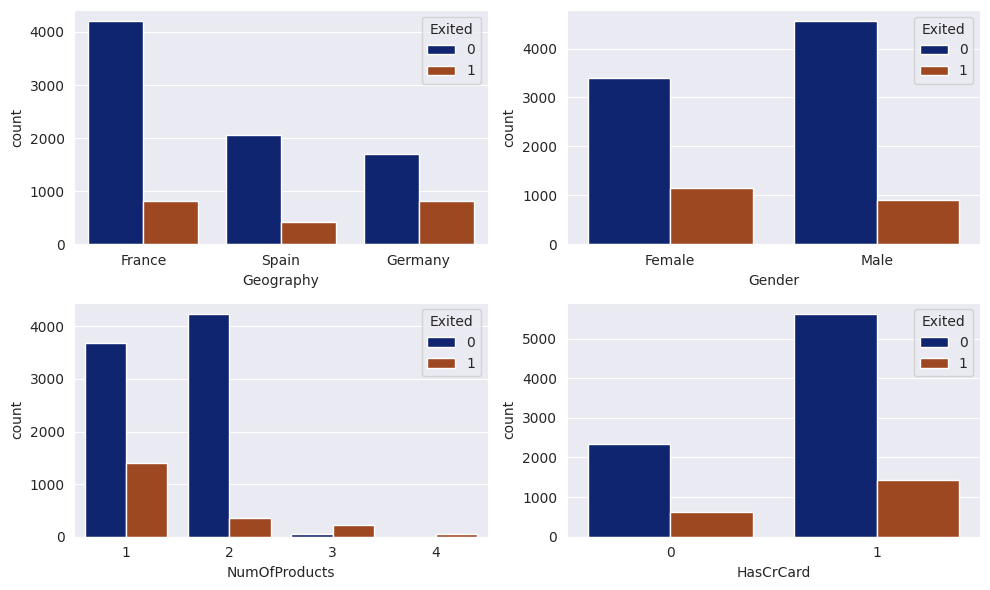

In [ ]:
categorical = df.drop(columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary'])
rows = int(np.ceil(categorical.shape[1] / 2)) - 1

# create sub-plots anf title them
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10,6))
axes = axes.flatten()

for row in range(rows):
    cols = min(2, categorical.shape[1] - row*2)
    for col in range(cols):
        col_name = categorical.columns[2 * row + col]
        ax = axes[row*2 + col]       

        sns.countplot(data=categorical, x=col_name, hue="Exited", ax=ax);
        
plt.tight_layout()

In [ ]:
def box_scatter(data, x, y):    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
    sns.boxplot(data=data, x=x, ax=ax1)
    sns.scatterplot(data=data, x=x,y=y,ax=ax2)

# of Bivariate Outliers: 19


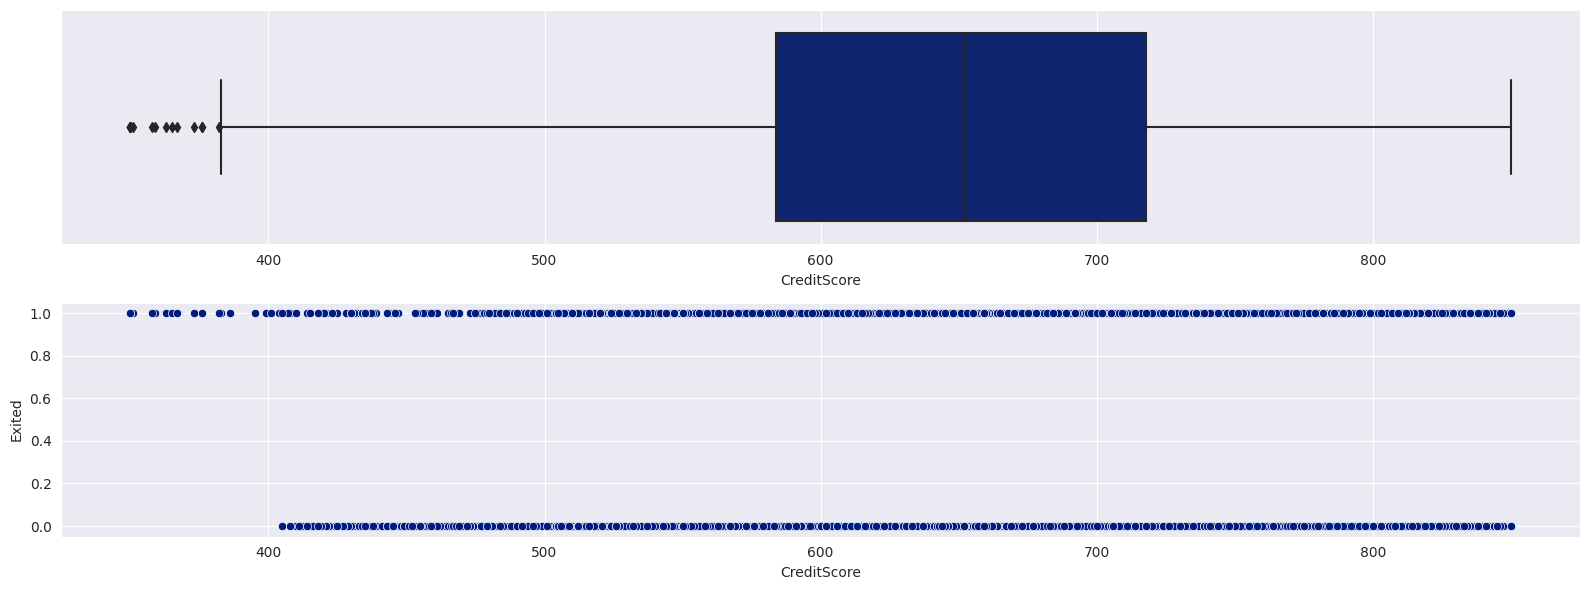

In [ ]:
box_scatter(df,'CreditScore','Exited');
plt.tight_layout()
print(f"# of Bivariate Outliers: {len(df.loc[df['CreditScore'] < 400])}")

In [ ]:
X = df.drop(columns=['Exited'])
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:

def untuned(X_train, X_test, y_train, y_test):
    lr = LogisticRegression()
    knn = KNeighborsClassifier()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    ada = AdaBoostClassifier()
    lgb = LGBMClassifier()
    xgb = XGBClassifier()
   
    
    names = ['Linear Regression', 'KNN', 'DT', 'RF', 'AdaBoost', 'Light GBM', 'XGBoost']
    algos = [lr, knn, dt, rf, ada, lgb, xgb]
    acc = [None] * 7
    precision = [None] * 7
    recall = [None] * 7
    f1 = [None] * 7
    
    for indx, model in enumerate(algos):
        try:
            if(indx < 7):
                model.fit(X_train, y_train)
            else:
                model.fit(X_train, y_train, silent=True)
                
            y_pred = model.predict(X_test)
            acc[indx] = model.score(X_test, y_test)            
            precision[indx] = precision_score(y_test, y_pred)
            recall[indx] = recall_score(y_test, y_pred)
            f1[indx] = f1_score(y_test, y_pred)
            
        except Exception as e:
            acc[indx] = "-"
            precision[indx] = "-"
            recall[indx] = "-"
            f1[indx] = "-"
            print(f"{names[indx]}: {str(e)}")
        
    return pd.DataFrame([acc, precision, recall, f1],
                        index=['Accuracy', 'Precision', 'Recall', 'F1'],columns=names).T

In [ ]:
nothing = untuned(X_train, X_test, y_train, y_test)
nothing

,Accuracy,Precision,Recall,F1
Linear Regression,0.784000,0.363636,0.057971,0.100000
KNN,0.756000,0.255507,0.093398,0.136792
DT,0.803333,0.523449,0.557166,0.539782
RF,0.866000,0.761337,0.513688,0.613462
AdaBoost,0.861333,0.733485,0.518519,0.607547
Light GBM,0.861000,0.724670,0.529791,0.612093
XGBoost,0.855667,0.702586,0.524960,0.600922


In [ ]:
encoding = untuned(X_train, X_test, y_train, y_test)
encoding

,Accuracy,Precision,Recall,F1
Linear Regression,0.784000,0.363636,0.057971,0.100000
KNN,0.756000,0.255507,0.093398,0.136792
DT,0.798333,0.511905,0.553945,0.532096
RF,0.865000,0.758373,0.510467,0.610202
AdaBoost,0.861333,0.733485,0.518519,0.607547
Light GBM,0.861000,0.724670,0.529791,0.612093
XGBoost,0.855667,0.702586,0.524960,0.600922


In [ ]:
ss = StandardScaler()
X = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
scaling = untuned(X_train, X_test, y_train, y_test)
scaling

,Accuracy,Precision,Recall,F1
Linear Regression,0.806667,0.584362,0.228663,0.328704
KNN,0.827667,0.629353,0.407407,0.494624
DT,0.798333,0.511799,0.558776,0.534257
RF,0.866667,0.768856,0.508857,0.612403
AdaBoost,0.861333,0.733485,0.518519,0.607547
Light GBM,0.860333,0.721491,0.529791,0.610956
XGBoost,0.855667,0.702586,0.524960,0.600922


In [ ]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
imbalance = untuned(X_train, X_test, y_train, y_test)
imbalance

,Accuracy,Precision,Recall,F1
Linear Regression,0.715781,0.718935,0.710526,0.714706
KNN,0.833822,0.780112,0.930660,0.848762
DT,0.830892,0.819758,0.849206,0.834222
RF,0.889703,0.885266,0.895990,0.890596
AdaBoost,0.819171,0.820620,0.817878,0.819247
Light GBM,0.903516,0.923718,0.880117,0.901390
XGBoost,0.903516,0.920035,0.884294,0.901810
